In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# NLP
NLP, is a branch of artificial intelligence that deals with the interaction between computers and humans using the natural language. The objective of NLP is to read, decipher, understand, and make sense of the human languages in a manner that is valuable. So lets start.

Lets get all the important libraries we need in this task.

In [ ]:
# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

Here we are building a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have a dataset of  around 10000 tweets. So basically its a classification problem.

For this purpose we can use various algorithms like - 

# Logistic Regression

# XGBoost

# Naive Bayes.

I will Naive Bayes algorithm here specifically; Thats the first algorithm i always use when i deal with something like this. Its a pretty good algorithm.

# So What is Naive Bayes algorithm and how it works.--

Naïve Bayes algorithm is a supervised learning algorithm, which is based on Bayes theorem.

It is mainly used in text classification that includes a high-dimensional training dataset.

It is a probabilistic classifier, which means it predicts on the basis of the probability of an object.

# Why is it called Naïve Bayes?

The Naïve Bayes algorithm is comprised of two words Naïve and Bayes, Which can be described as:

Naïve: It is called Naïve because it assumes that the occurrence of a certain feature is independent of the occurrence of other features. Such as if the fruit is identified on the bases of color, shape, and taste, then red, spherical, and sweet fruit is recognized as an apple. Hence each feature individually contributes to identify that it is an apple without depending on each other.

Bayes: It is called Bayes because it depends on the principle of Bayes' Theorem.

# Bayes' Theorem:
Bayes' theorem is also known as Bayes' Rule or Bayes' law, which is used to determine the probability of a hypothesis with prior knowledge. It depends on the conditional probability.It states, for two events A & B, if we know the conditional probability of B given A and the probability of B, then it’s possible to calculate the probability of B given A

Formula for Bayes Theorem - 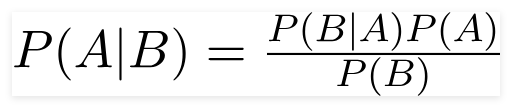


# Import the data

In [ ]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

# Missing Values
First thing first. Lets find out the quality of our data. We will check the missing values

In [ ]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
percent_missing

In [ ]:
percent_missing2 = df_test.isnull().sum() * 100 / len(df_test)
percent_missing2

So, we have around 33% of the values missing in location column in both the datasets.

# Distribution of target variable.
Now, Lets check the distribution of our target variable

In [ ]:
df_train['target'].value_counts(normalize=True)

I would say its a fair distribution- 57% and 43%. There are many instnaces where we might have to work with a data where target variable in hughly inbalanced but here Its fine. SO we don't need to worry much about the distribution of target variable

# Data Visualisation
How many words are in a tweet ?

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Most common stopwords

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
from collections import defaultdict
stop=set(stopwords.words('english'))

corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

# Data Cleaning
Lets start with the cleaning.

I would do the cleaning in couple of rounds.

1st round - We will remove punctuations, and numbers, will convert into lowercase,remove any brackets, etc.

2nd round - We will get rid of some additional punctatuions, and non-sensical text that we might have missed in the first round.

3rd round - I will get rid of https, #, www. , etc.

This is just to explain how can we approach towards cleaning our text. All of these three rounds of cleaning can be done in just one round as well by writing one function only.

In [ ]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)
# Let's take a look at the updated text
df_train['text'] = pd.DataFrame(df_train['text'].apply(round1))
df_test['text'] = pd.DataFrame(df_test['text'].apply(round1))
df_train.head()

In [ ]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)
# Let's take a look at the updated text
df_train['text'] = pd.DataFrame(df_train['text'].apply(round2))
df_test['text'] = pd.DataFrame(df_test['text'].apply(round2))
df_train.head()

In [ ]:
def clean_text_round3(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    return text
round3 = lambda x: clean_text_round3(x)

# Applying the cleaning function to both test and training datasets
df_train['text'] = pd.DataFrame(df_train['text'].apply(round3))
df_test['text'] = pd.DataFrame(df_test['text'].apply(round3))
df_train.head()

# Tokenization
Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords.[](http://)

In [ ]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
df_train['text'] = df_train['text'].apply(lambda x: tokenizer.tokenize(x))
df_test['text'] = df_test['text'].apply(lambda x: tokenizer.tokenize(x))
df_train.head()

# Stopwords Removal

When we deal with text problem in Natural Language Processing, stop words removal process is a one of the important step to have a better input for any models. Stop words means that it is a very common words in a language (e.g. a, an, the in English). It does not help on most of NLP problem such as semantic analysis, classification etc.

Word tokenization and lemmatization are the essential part for removing stop words.

In [ ]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

df_train['text'] = df_train['text'].apply(lambda x : remove_stopwords(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_stopwords(x))
df_train.head()

Word Clouds
Word clouds are on the most population visulations method when it comes to text data. Its looks good and I quite like word clouds. They tells the stroy hidden in the text in a beautiful manner. 

So, Lets create two word clouds. One for disaster tweets and another of Non Disaster tweets.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_train[df_train["target"]==1], title="Word Cloud of disaster tweets")

In [ ]:
plot_wordcloud(df_train[df_train["target"]==0], title="Word Cloud of not real disaster tweets")

Here we are just taking a list of text and combines them into one large chunk of text.

In [ ]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

df_train['text'] = df_train['text'].apply(lambda x : combine_text(x))
df_test['text'] = df_test['text'].apply(lambda x : combine_text(x))
df_train.head()

Top Ngrams, I am analysing Bigrams only (n=2)

In [ ]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize=(10,5))
top_bigrams=get_top_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

Now we have cleaned our text. We have remove almost all the noise from the data. Now question comes how to transform this data into something meaningful from which our machine can make some sense out it. There are various techniques to transform text into a meaningful vector of numbers. 

We can use - 

1) Bag of word

2) TFIDF Features


# Bag of Words - Countvectorizer

It converts a collection of text documents to a matrix of token counts.

In [ ]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_train['text'])
test_vectors = count_vectorizer.transform(df_test['text'])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

# TFIDF Features

Term Frequency: is a scoring of the frequency of the word in the current document.

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test["text"])

# Modelling

Fitting a simple Naive Bayes on Count of words

In [ ]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, df_train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf_NB.fit(train_vectors, df_train["target"])

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, df_train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf_NB_TFIDF.fit(train_tfidf, df_train["target"])

In [ ]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)

........To be Continued

Please support by likes and upovotes. It will motivate me.